In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import sklearn.datasets

In [4]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [5]:
def remove_label(df):
    # Extract the 'HeartDisease' column as the labels
    labels = df['HeartDisease'].copy()
    
    # Remove the 'HeartDisease' column from the dataframe
    df_without_heart_disease = df.drop(columns=['HeartDisease'])
    
    # Return the modified DataFrame and the labels
    return df_without_heart_disease, labels

def process_cat_vars(df):
    """
    Function to preprocess the data, including encoding categorical variables and 
    applying one-hot encoding to certain columns. This function is designed to be applied
    to both the training and test sets.
    
    Parameters:
    df (DataFrame): The input dataframe containing the features and the target label.

    Returns:
    DataFrame: The preprocessed dataframe
    """
    # Encode categorical variables
    # Male is 1, female is 0 for 'Sex'
    df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
    
    # 'ExerciseAngina' : Yes is 1 and No is 0
    df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})
    
    # 'ST_Slope': Up is 1, Flat is 0, Down is -1
    df['ST_Slope'] = df['ST_Slope'].map({'Up': 1, 'Flat': 0, 'Down': -1})

    # One hot encoding for categorical columns that have more than two categories
    df_encoded = pd.get_dummies(df, columns=['ChestPainType', 'RestingECG'], dtype=int)
    
    return df_encoded

def handle_outliers(df):
     # Set outlier cholesterol values to NaN
    df.loc[df['Cholesterol'] < 50, 'Cholesterol'] = np.nan
    df.loc[df['Cholesterol'] > 400, 'Cholesterol'] = np.nan

    # Set outlier resting BP values to NaN
    df.loc[df['RestingBP'] < 30, 'RestingBP'] = np.nan

    return df.copy()

def pre_process(df):
    df = process_cat_vars(df)
    return handle_outliers(df)

In [6]:
df_train = pd.read_csv(os.path.join('heart_failure', 'train_val_split.csv'))
df_test = pd.read_csv(os.path.join('heart_failure', 'test_split.csv'))

In [7]:
X_train, Y_train = remove_label(df_train)
X_test, Y_test = remove_label(df_test)

In [8]:
X_train = pre_process(X_train)
X_test = pre_process(X_test)
X_train.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,40,1,140.0,289.0,0,172,0,0.0,1,0,1,0,0,0,1,0
1,37,1,130.0,283.0,0,98,0,0.0,1,0,1,0,0,0,0,1
2,48,0,138.0,214.0,0,108,1,1.5,0,1,0,0,0,0,1,0
3,54,1,150.0,195.0,0,122,0,0.0,1,0,0,1,0,0,1,0
4,39,1,120.0,339.0,0,170,0,0.0,1,0,0,1,0,0,1,0


In [9]:
cholesterol_median = X_train['Cholesterol'].median()
restingbp_median = X_train['RestingBP'].median()

X_train['Cholesterol'] = X_train['Cholesterol'].fillna(cholesterol_median)
X_train['RestingBP'] = X_train['RestingBP'].fillna(restingbp_median)

X_test['Cholesterol'] = X_test['Cholesterol'].fillna(cholesterol_median)
X_test['RestingBP'] = X_test['RestingBP'].fillna(restingbp_median)

In [10]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
X_train_scaled

array([[-1.07692308,  0.        ,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [-1.30769231,  0.        ,  0.        , ...,  0.        ,
        -1.        ,  1.        ],
       [-0.46153846, -1.        ,  0.4       , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.69230769,  0.        , -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.07692308,  0.        ,  0.7       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.23076923,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [12]:
class ActivationLayer(nn.Module):
    def __init__(self, input_dim, num_units, activation='relu'):
        super().__init__()
        self.activation = activation
        if activation == 'relu':
            self.linear = nn.Linear(input_dim, num_units)
        elif activation == 'exu':
            self.beta = nn.Parameter(torch.empty(input_dim, num_units))
            self.c = nn.Parameter(torch.empty(1, num_units))
            nn.init.trunc_normal_(self.beta, mean=4.0, std=0.5)
            nn.init.trunc_normal_(self.c, std=0.5)
        else:
            raise ValueError("Unsupported activation type. Use 'relu' or 'exu'.")

    def forward(self, x):
        if self.activation == 'relu':
            return F.relu(self.linear(x))
        elif self.activation == 'exu':
            center = self.c.expand(x.shape[0], -1)
            return torch.clamp(torch.exp(self.beta) * (x - center), 0, 1)

# FeatureNN using ExU and additional dense layers (shallow = False)
class FeatureNN(nn.Module):
    def __init__(self, num_units, feature_idx, activation='relu'):
        super().__init__()
        self.activation = ActivationLayer(1, num_units, activation=activation)
        self.hidden1 = nn.Linear(num_units, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.linear = nn.Linear(32, 1, bias=False)
        self.feature_idx = feature_idx

    def forward(self, x):
        x = x[:, self.feature_idx].unsqueeze(1)  # [batch_size, 1]
        x = self.activation(x)                  # [batch_size, num_units]
        x = F.relu(self.hidden1(x))             # [batch_size, 64]
        x = F.relu(self.hidden2(x))             # [batch_size, 32]
        x = self.linear(x)                      # [batch_size, 1]
        return x.squeeze(1)                     # [batch_size]

# NAM model
class NAM(nn.Module):
    def __init__(self, input_dim, num_units=64, activation='relu'):
        super().__init__()
        self.feature_nns = nn.ModuleList([
            FeatureNN(num_units=num_units, feature_idx=i, activation=activation) for i in range(input_dim)
        ])
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        outputs = [fnn(x) for fnn in self.feature_nns]  # list of [batch_size]
        return torch.sigmoid(torch.stack(outputs, dim=1).sum(dim=1) + self.bias)


In [21]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, lr=0.001, batch_size=64):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    pos_weight = torch.tensor([Y_train.value_counts()[0] / Y_train.value_counts()[1]], dtype=torch.float32)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        with torch.no_grad():
            val_preds = torch.cat([model(xb.to(device)) for xb, _ in val_loader]).cpu().numpy()
            val_labels = torch.cat([yb for _, yb in val_loader]).numpy()
            val_preds_binary = (val_preds >= 0.5).astype(int)
            acc = accuracy_score(val_labels, val_preds_binary)
            f1 = f1_score(val_labels, val_preds_binary)
            print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Accuracy={acc:.4f}, F1={f1:.4f}")

    return model

# Evaluation function
def evaluate_model(model, X_test, y_test):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = model(X_tensor).cpu().numpy()
    preds_binary = (preds >= 0.5).astype(int)
    acc = accuracy_score(y_test, preds_binary)
    f1 = f1_score(y_test, preds_binary)
    bal_acc = balanced_accuracy_score(y_test, preds_binary)
    print(f"Test Accuracy: {acc:.4f}, F1-score: {f1:.4f}, Balanced Accuracy: {bal_acc:.4f}")
    return #preds
    
# Visualization of learned feature functions
def plot_feature_functions(model, feature_names, X):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    fig, axes = plt.subplots(len(feature_names)//2, 2, figsize=(12, len(feature_names)*2))
    axes = axes.flatten()
    for i, (name, fnn) in enumerate(zip(feature_names, model.feature_nns)):
        print(name)
        vals = torch.linspace(X[:, i].min(), X[:, i].max(), steps=100).to(device)
        input_matrix = torch.zeros((100, X.shape[1]), device=device)
        input_matrix[:, i] = vals
        with torch.no_grad():
            out = fnn(input_matrix).cpu().numpy()
        axes[i].plot(vals.cpu().numpy(), out)
        axes[i].set_title(name)
        axes[i].set_xlabel(f"{name} value")
        axes[i].set_ylabel("Contribution to logit")
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, X, feature_names):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        contributions = []
        for i, fnn in enumerate(model.feature_nns):
            out = fnn(X_tensor).cpu().numpy()
            abs_mean = np.mean(np.abs(out))  # mean absolute contribution
            contributions.append(abs_mean)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(feature_names)), contributions, color='orangered', label='NAMs')
    plt.xticks(range(len(feature_names)), feature_names, rotation=90)
    plt.ylabel("Mean Absolute Score")
    plt.title("Overall Importance")
    plt.legend()
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [14]:
model = NAM(input_dim=X_train_scaled.shape[1], num_units=64, activation='exu')

/cluster/courses/ml4h/project1env/lib/python3.12/site-packages/torch/nn/init.py:224: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b, generator=generator)


In [15]:
trained_model = train_model(model, X_train_scaled, Y_train, X_test_scaled, Y_test, epochs=40)

Epoch 1: Loss=0.6148, Accuracy=0.7663, F1=0.7749
Epoch 2: Loss=0.5634, Accuracy=0.7880, F1=0.8060
Epoch 3: Loss=0.5398, Accuracy=0.8098, F1=0.8357
Epoch 4: Loss=0.5312, Accuracy=0.8098, F1=0.8341
Epoch 5: Loss=0.5277, Accuracy=0.8261, F1=0.8505
Epoch 6: Loss=0.5248, Accuracy=0.8207, F1=0.8465
Epoch 7: Loss=0.5231, Accuracy=0.8261, F1=0.8519
Epoch 8: Loss=0.5215, Accuracy=0.8370, F1=0.8598
Epoch 9: Loss=0.5210, Accuracy=0.8315, F1=0.8545
Epoch 10: Loss=0.5198, Accuracy=0.8261, F1=0.8491
Epoch 11: Loss=0.5184, Accuracy=0.8370, F1=0.8611
Epoch 12: Loss=0.5181, Accuracy=0.8424, F1=0.8676
Epoch 13: Loss=0.5166, Accuracy=0.8533, F1=0.8767
Epoch 14: Loss=0.5155, Accuracy=0.8370, F1=0.8611
Epoch 15: Loss=0.5146, Accuracy=0.8315, F1=0.8584
Epoch 16: Loss=0.5147, Accuracy=0.8370, F1=0.8585
Epoch 17: Loss=0.5133, Accuracy=0.8261, F1=0.8532
Epoch 18: Loss=0.5136, Accuracy=0.8207, F1=0.8479
Epoch 19: Loss=0.5125, Accuracy=0.8315, F1=0.8531
Epoch 20: Loss=0.5113, Accuracy=0.8261, F1=0.8491
Epoch 21:

In [19]:
evaluate_model(trained_model, X_test_scaled, Y_test)

Test Accuracy: 0.8261, F1-score: 0.8545, Balanced Accuracy: 0.8192


Age
Sex
RestingBP
Cholesterol
FastingBS
MaxHR
ExerciseAngina
Oldpeak
ST_Slope
ChestPainType_ASY
ChestPainType_ATA
ChestPainType_NAP
ChestPainType_TA
RestingECG_LVH
RestingECG_Normal
RestingECG_ST


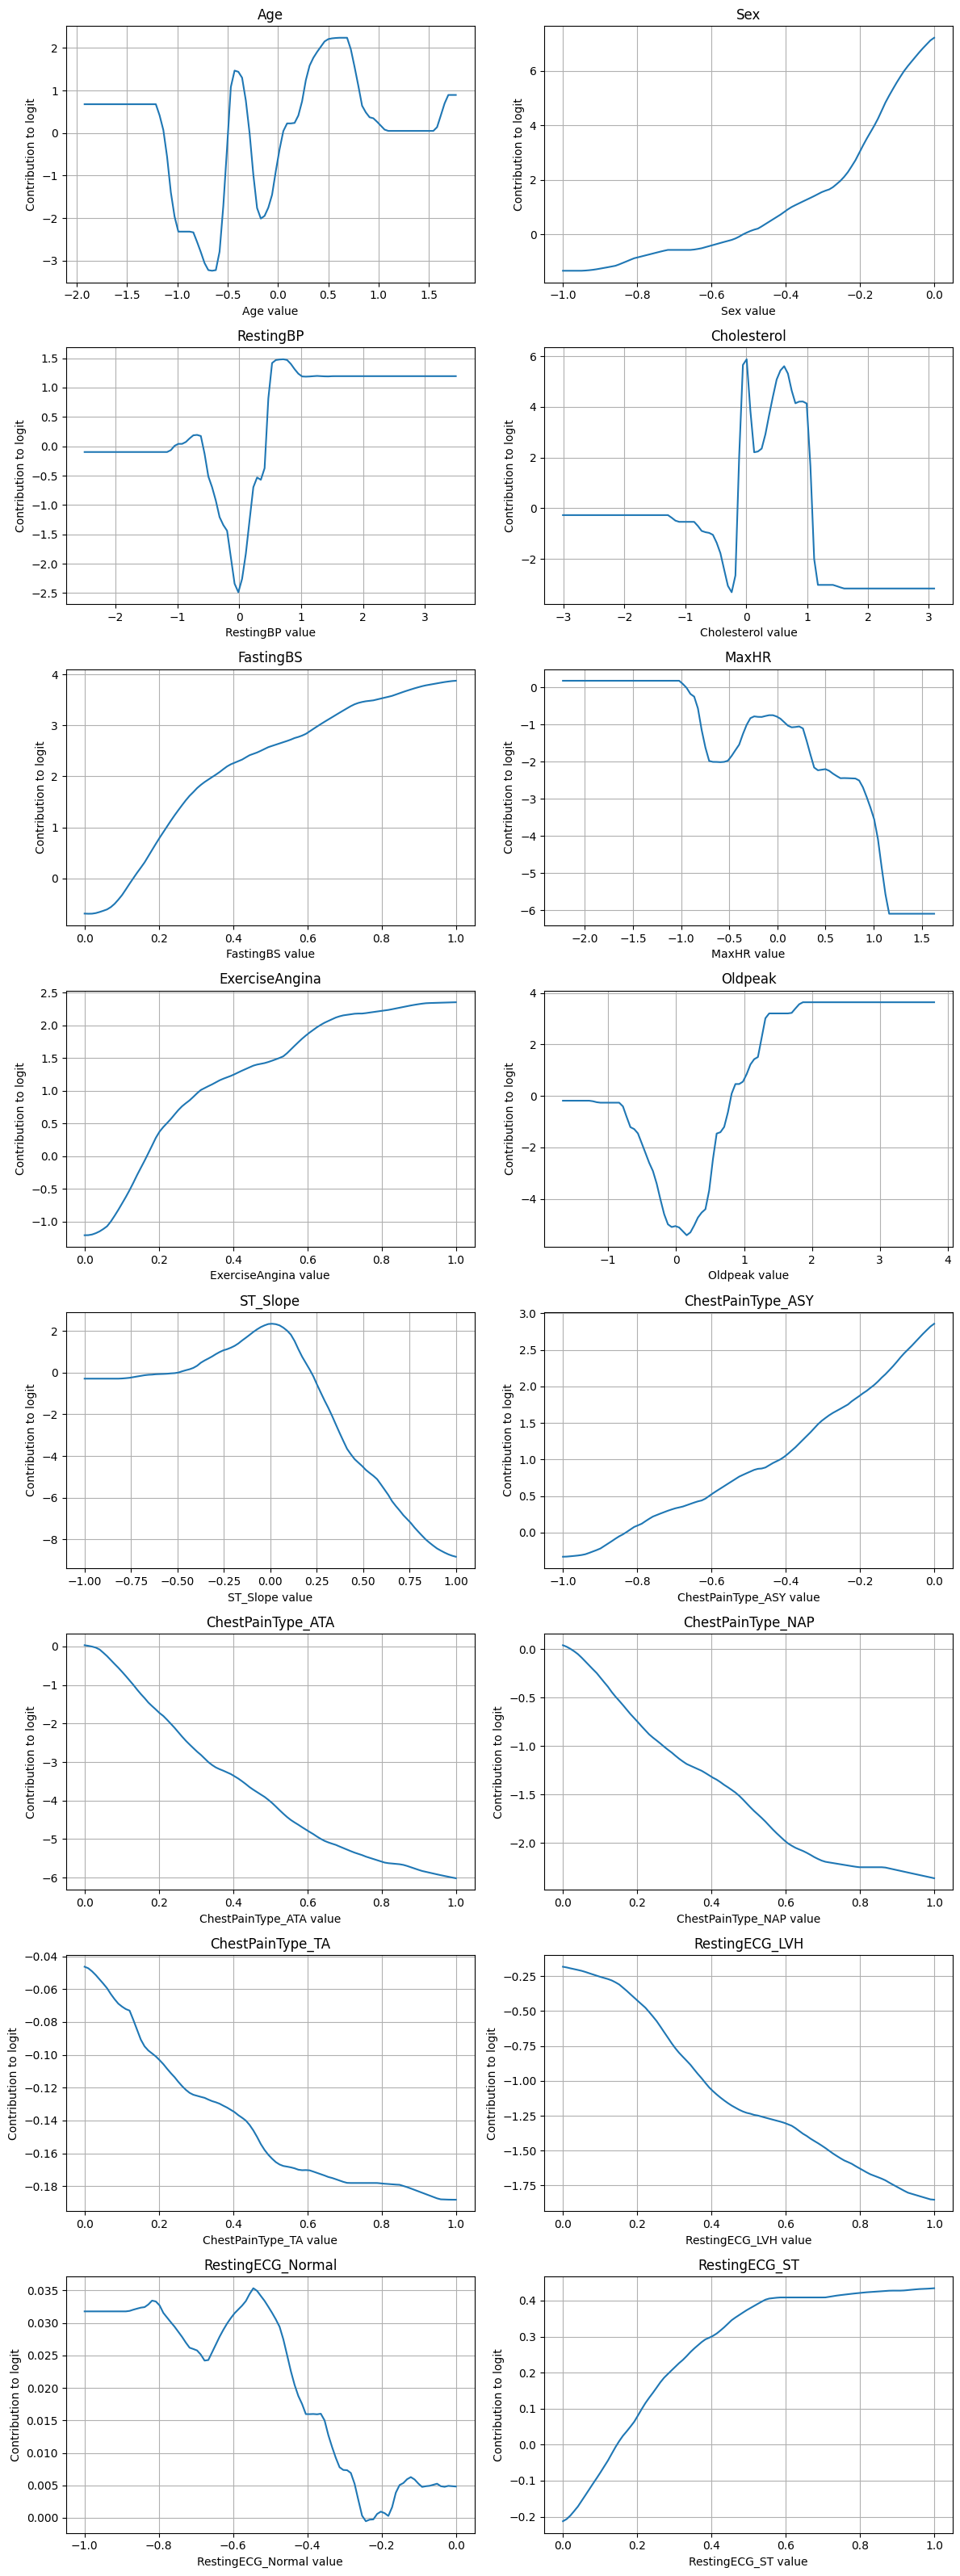

In [20]:
plot_feature_functions(trained_model, X_train.columns.tolist(), X_train_scaled)

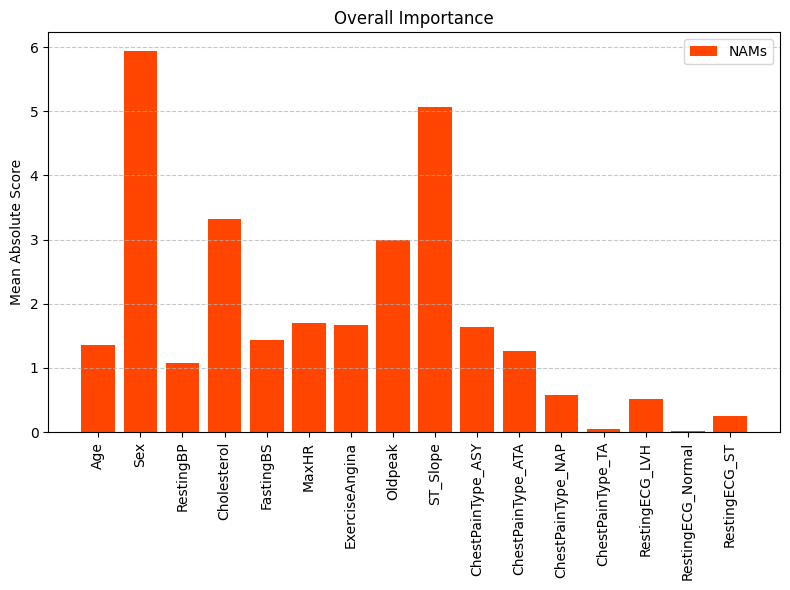

In [22]:
plot_feature_importance(trained_model, X_train_scaled, X_train.columns.tolist())